In [1]:
# Import the dependencies
import psycopg2
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import API key
from password import postgres_password

In [3]:
# Establish the connection
conn = psycopg2.connect(database="project_4",
                        user="postgres",
                        password=postgres_password,
                        host="localhost",
                        port="5432"
)

# Import and read the employee_attrition.csv from SQL
attrition_df = pd.read_sql_query('''SELECT * from attrition''', conn)

# Close the connection
conn.close()

C:\Users\danie\AppData\Local\Temp\ipykernel_24900\1457670229.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  attrition_df = pd.read_sql_query('''SELECT * from attrition''', conn)


In [4]:
# Review dataframe
attrition_df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,...,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [5]:
# Determine the number of unique values in each column.
attrition_df.nunique()

age                           43
attrition                      2
businesstravel                 3
dailyrate                    886
department                     3
distancefromhome              29
education                      5
educationfield                 6
employeecount                  1
employeenumber              1470
environmentsatisfaction        4
gender                         2
hourlyrate                    71
jobinvolvement                 4
joblevel                       5
jobrole                        9
jobsatisfaction                4
maritalstatus                  3
monthlyincome               1349
monthlyrate                 1427
numcompaniesworked            10
over18                         1
overtime                       2
percentsalaryhike             15
performancerating              2
relationshipsatisfaction       4
standardhours                  1
stockoptionlevel               4
totalworkingyears             40
trainingtimeslastyear          7
worklifeba

In [6]:
# Drop unnecessary and redundant columns
del attrition_df["employeecount"]
del attrition_df["employeenumber"]
del attrition_df["over18"]
del attrition_df["standardhours"]
del attrition_df["dailyrate"]
del attrition_df["hourlyrate"]
del attrition_df["monthlyrate"]

attrition_df.head()

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,jobinvolvement,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,...,3,4,1,6,3,3,2,2,2,2


In [7]:
# Create a custum function to encode binary columns
def encode_column(column):
    if (column == "Yes") | (column == "Male"):
        return 1
    else:
        return 0

In [8]:
# Apply custom function to columns with binary data
attrition_df["attrition"] = attrition_df["attrition"].apply(encode_column)
attrition_df["gender"] = attrition_df["gender"].apply(encode_column)
attrition_df["overtime"] = attrition_df["overtime"].apply(encode_column)
attrition_df.head()

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,jobinvolvement,...,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,1,Travel_Rarely,Sales,1,2,Life Sciences,2,0,3,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,Research & Development,8,1,Life Sciences,3,1,2,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,Research & Development,2,2,Other,4,1,2,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,Research & Development,3,4,Life Sciences,4,0,3,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,Research & Development,2,1,Medical,1,1,3,...,3,4,1,6,3,3,2,2,2,2


In [9]:
# Convert categorical data to numeric with `pd.get_dummies`
converted_df = pd.get_dummies(attrition_df, columns=["businesstravel", "department", "educationfield", "jobrole", "maritalstatus"], dtype="int")
converted_df.head()


,age,attrition,distancefromhome,education,environmentsatisfaction,gender,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,41,1,1,2,2,0,3,2,4,5993,...,0,0,0,0,0,1,0,0,0,1
1,49,0,8,1,3,1,2,2,2,5130,...,0,0,0,0,1,0,0,0,1,0
2,37,1,2,2,4,1,2,1,3,2090,...,1,0,0,0,0,0,0,0,0,1
3,33,0,3,4,4,0,3,1,3,2909,...,0,0,0,0,1,0,0,0,1,0
4,27,0,2,1,1,1,3,1,2,3468,...,1,0,0,0,0,0,0,0,1,0


In [10]:
# Split our preprocessed data into our features and target arrays
y = converted_df["attrition"]
X = converted_df.drop(columns=["attrition", "age", "monthlyincome", "education", "percentsalaryhike"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    stratify=y)

In [11]:
# Review targets
pd.DataFrame(y).head()

,attrition
0,1
1,0
2,1
3,0
4,0


In [12]:
# Review features
X.head()

,distancefromhome,environmentsatisfaction,gender,jobinvolvement,joblevel,jobsatisfaction,numcompaniesworked,overtime,performancerating,relationshipsatisfaction,...,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Divorced,maritalstatus_Married,maritalstatus_Single
0,1,2,0,3,2,4,8,1,3,1,...,0,0,0,0,0,1,0,0,0,1
1,8,3,1,2,2,2,1,0,4,4,...,0,0,0,0,1,0,0,0,1,0
2,2,4,1,2,1,3,6,1,3,2,...,1,0,0,0,0,0,0,0,0,1
3,3,4,0,3,1,3,1,1,3,3,...,0,0,0,0,1,0,0,0,1,0
4,2,1,1,3,1,2,9,0,3,4,...,1,0,0,0,0,0,0,0,1,0


In [13]:
# Create model
model = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)
model

LogisticRegression(max_iter=200, random_state=1)

In [14]:
# Fit training data to model
model.fit(X_train, y_train)

c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=1)

In [15]:
# Calculate model coefficients
coefs = model.coef_[0]
coefs

array([ 0.04657684, -0.44471637,  0.45854008, -0.5086737 , -0.41009603,
       -0.4363331 ,  0.16980714,  1.66679119, -0.13015138, -0.24339051,
       -0.17643722, -0.06028077, -0.18077957, -0.4235433 ,  0.13063894,
       -0.16195397,  0.1521779 , -0.14705116, -0.74051304,  0.90874749,
        0.10695833, -0.05351339, -0.20816465,  0.53687083,  0.52332935,
       -0.44192512,  0.13166517, -0.35134307, -0.34683243,  0.76029889,
       -0.2032594 ,  0.60710792,  0.78566536, -0.44532437,  0.14877785,
       -0.54877944, -0.2141394 , -0.26591381,  0.41105806, -0.54543507,
       -0.03934763,  0.85997548])

In [16]:
# Create feature importance dataframe
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefs)}).sort_values('Importance', ascending=True).reset_index(drop=True)
feature_importance_df.head()

,Feature,Importance
0,maritalstatus_Married,0.039348
1,distancefromhome,0.046577
2,department_Human Resources,0.053513
3,totalworkingyears,0.060281
4,businesstravel_Travel_Rarely,0.106958


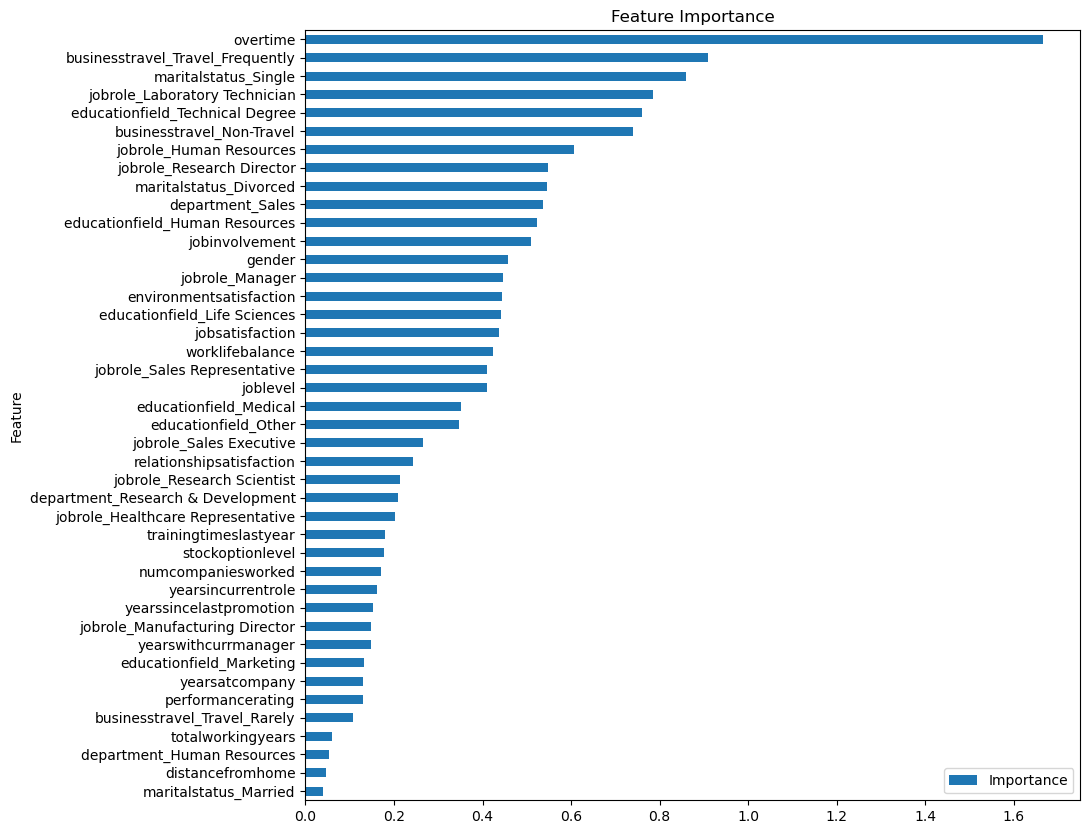

In [17]:
# Create feature importance bar plot
feature_importance_df.plot(kind="barh", x="Feature", y="Importance", figsize=(10,10))
plt.title("Feature Importance")
plt.savefig("feature_importance", bbox_inches = 'tight')
plt.show()

In [18]:
base_estimator = LogisticRegression()
rfe = RFE(estimator=base_estimator, n_features_to_select=5, verbose=1)
rfe.fit(X_train, y_train)

X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

selected_features = X.columns[rfe.get_support()]
print(f"Selected features: {', '.join(selected_features)}")

Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.


c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.


c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.


c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.


c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\danie\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Selected features: overtime, jobrole_Manager, jobrole_Research Director, jobrole_Sales Representative, maritalstatus_Single


In [19]:
# Print scores
print(f"Training Data Score: {model.score(X_train, y_train)}")
print(f"Testing Data Score: {model.score(X_test, y_test)}")

Training Data Score: 0.8883847549909256
Testing Data Score: 0.8614130434782609


In [20]:
# Make predictions on testing data
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,0,0
1,0,0
2,1,0
3,1,0
4,0,0


In [21]:
# Display the accuracy score for the test dataset.
accuracy_score(y_test, predictions)

0.8614130434782609

In [22]:
# Generate the confusion matrix for the model
confusion_matrix(y_test, predictions)

array([[293,  16],
       [ 35,  24]], dtype=int64)

In [23]:
# Print the classification report for the model
target_names = ["Attrition", "No Attrition"]
print(classification_report(y_test, predictions, target_names = target_names))

              precision    recall  f1-score   support

   Attrition       0.89      0.95      0.92       309
No Attrition       0.60      0.41      0.48        59

    accuracy                           0.86       368
   macro avg       0.75      0.68      0.70       368
weighted avg       0.85      0.86      0.85       368

